## Trade and Logistics Study Project

###  This project analyzed data on the number people travlling between New Zealand and other Coutries (2018), trade volumn (2018) between New Zealand and other Coutries, distribution of world major trade fairs, and the number of perosperous cities of New Zealand major trading partners. 

In [3]:
# Prepare libraries and tools for this analysis 

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import itertools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # library to handle JSON files

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


# import k-means from clustering stage
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c anaconda seaborn -y
import folium # map rendering library

print('Libraries imported.')

%matplotlib inline

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  24.79 MB/s
geopy-1.18.1-p 100% |################################| Time: 0:00:00  36.74 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  53.60 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  36.60 MB/s
vincent-0.4.4- 100% |###################

### Load data of the number of people travelling between New Zealand and other countires (including immigrants and travellers)
#### (The data were orignially downloaded from https://www.stats.govt.nz/ and uploaded into this project)

In [4]:
# Load trade data 
import sys
import types
from ibm_botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_07372cc626c741c88132a22ad6924a1f = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='xTYRH0epnZJl0QSC9JXoX4KEWbEMQb-F21Y4Lw0eGOhO',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_07372cc626c741c88132a22ad6924a1f.get_object(Bucket='capstoneproject-donotdelete-pr-nkpipwybtggqgm',Key='itm-oct18-vis-res-by-country.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

travel_df = pd.read_csv(body)



In [5]:
travel_df.drop(['Period','Passenger_type','Direction'], axis=1, inplace=True)
travel_df.at[travel_df[travel_df['Country']=='Macau (Special Administrative Region)'].index,'Country']='China'
travel_df.at[travel_df[travel_df['Country']=='Hong Kong (Special Administrative Region)'].index,'Country']='China'
travel_df.at[travel_df[travel_df['Country']=='Taiwan'].index,'Country']='China'
travel_df.at[travel_df[travel_df['Country']=='China, People\'s Republic of'].index,'Country']='China'
travel_df = travel_df.groupby(['Country'])['Count'].sum()
travel_df = travel_df.reset_index('Country')
travel_df.sort_values(by='Count',ascending=False, axis=0, inplace=True)
travel_df.shape

(237, 2)

In [6]:
travel_top20=travel_df.head(20)
travel_top20['Count']=travel_top20['Count']/1000000
travel_top20

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Country,Count
11,Australia,12.290888
41,China,3.532305
223,United States of America,2.490462
221,United Kingdom,1.755115
104,Japan,0.723610
70,Fiji,0.696805
157,Not Stated,0.656671
81,Germany,0.653197
110,"Korea, Republic of",0.575040
96,India,0.546738


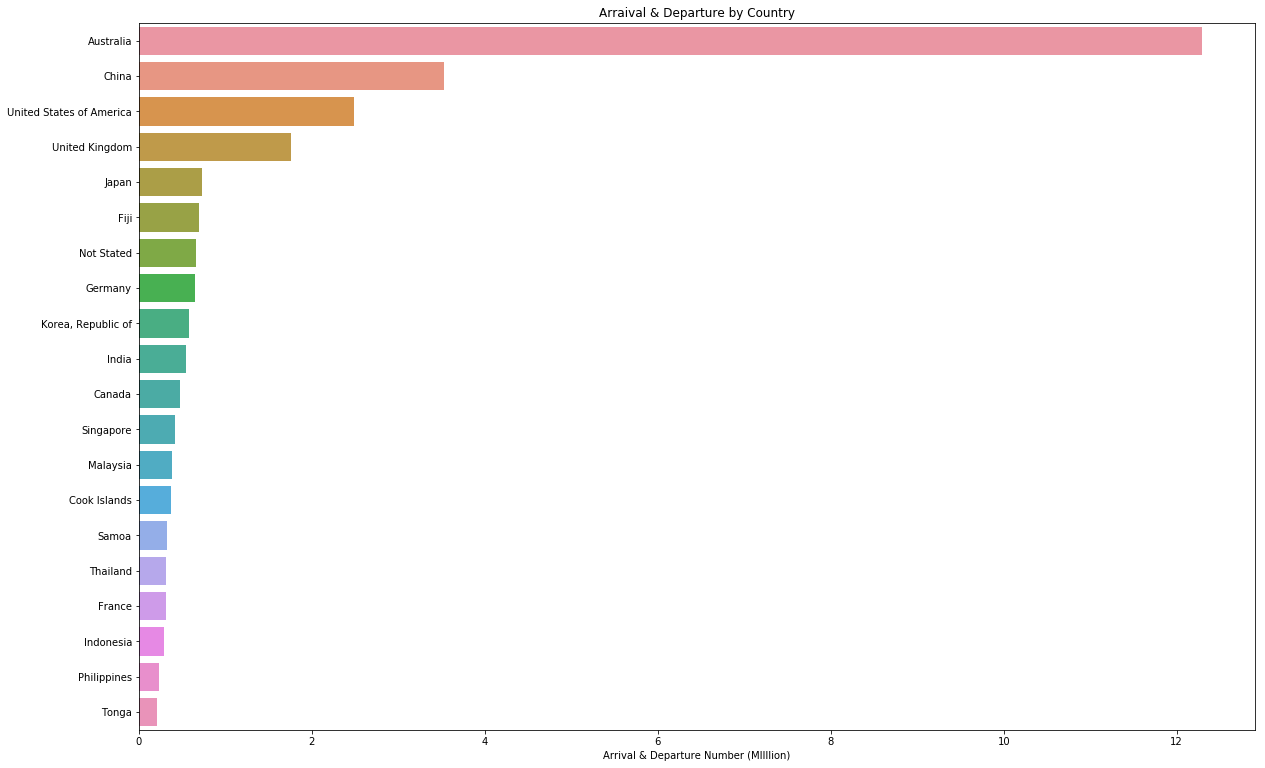

In [7]:
import seaborn as sns 
plt.figure(figsize=(20,13))
g=sns.barplot(x='Count',y='Country',data=travel_top20)
g.set(xlabel='Arrival & Departure Number (MIlllion)',ylabel='') 
plt.title('Arraival & Departure by Country')
plt.show()

### Load data on internaltinal trade of New Zealand (importing and export data)

In [8]:
# import data
body = client_07372cc626c741c88132a22ad6924a1f.get_object(Bucket='capstoneproject-donotdelete-pr-nkpipwybtggqgm',Key='2018-nz_import-by-country.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

import_df = pd.read_csv(body)

# export data 
body = client_07372cc626c741c88132a22ad6924a1f.get_object(Bucket='capstoneproject-donotdelete-pr-nkpipwybtggqgm',Key='2018-NZ-export-by-country.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

export_df = pd.read_csv(body)

In [9]:
export_df.drop('Month', axis=1, inplace =True)
export_df.at[export_df[export_df['Country']=='Macau (Special Administrative Region)'].index,'Country']='China'
export_df.at[export_df[export_df['Country']=='Hong Kong (Special Administrative Region)'].index,'Country']='China'
export_df.at[export_df[export_df['Country']=='Taiwan'].index,'Country']='China'
export_df.at[export_df[export_df['Country']=='China, People\'s Republic of'].index,'Country']='China'
export_df=export_df.groupby(['Country'])['Value'].sum()
export_df= export_df.reset_index('Country')

In [10]:
import_df.drop('Month', axis=1, inplace =True)
import_df.at[import_df[import_df['Country']=='Macau (Special Administrative Region)'].index,'Country']='China'
import_df.at[import_df[import_df['Country']=='Hong Kong (Special Administrative Region)'].index,'Country']='China'
import_df.at[import_df[import_df['Country']=='Taiwan'].index,'Country']='China'
import_df.at[import_df[import_df['Country']=='China, People\'s Republic of'].index,'Country']='China'
import_df=import_df.groupby(['Country'])['Value'].sum()
import_df= import_df.reset_index('Country')

In [11]:
export_df.columns=['Country','ExportValue']
import_df.columns=['Country','ImportValue']

In [12]:
trade_df=export_df.merge(import_df,  on='Country', how='inner')
trade_df['Total']= trade_df['ExportValue']+trade_df['ImportValue']
trade_df.sort_values(by='Total', ascending =False,axis=0, inplace=True)
trade_df['Total']=trade_df['Total']/1000000 

In [13]:
trade_top20 = trade_df.head(20)
trade_top20.head(5)

,Country,ExportValue,ImportValue,Total
39,China,1.424642e+10,12002504394,26248.924834
11,Australia,8.258607e+09,6403643176,14662.250224
204,United States of America,5.065053e+09,5636474106,10701.526914
98,Japan,3.261505e+09,3787309616,7048.814862
103,"Korea, Republic of",1.617411e+09,2538057954,4155.468840


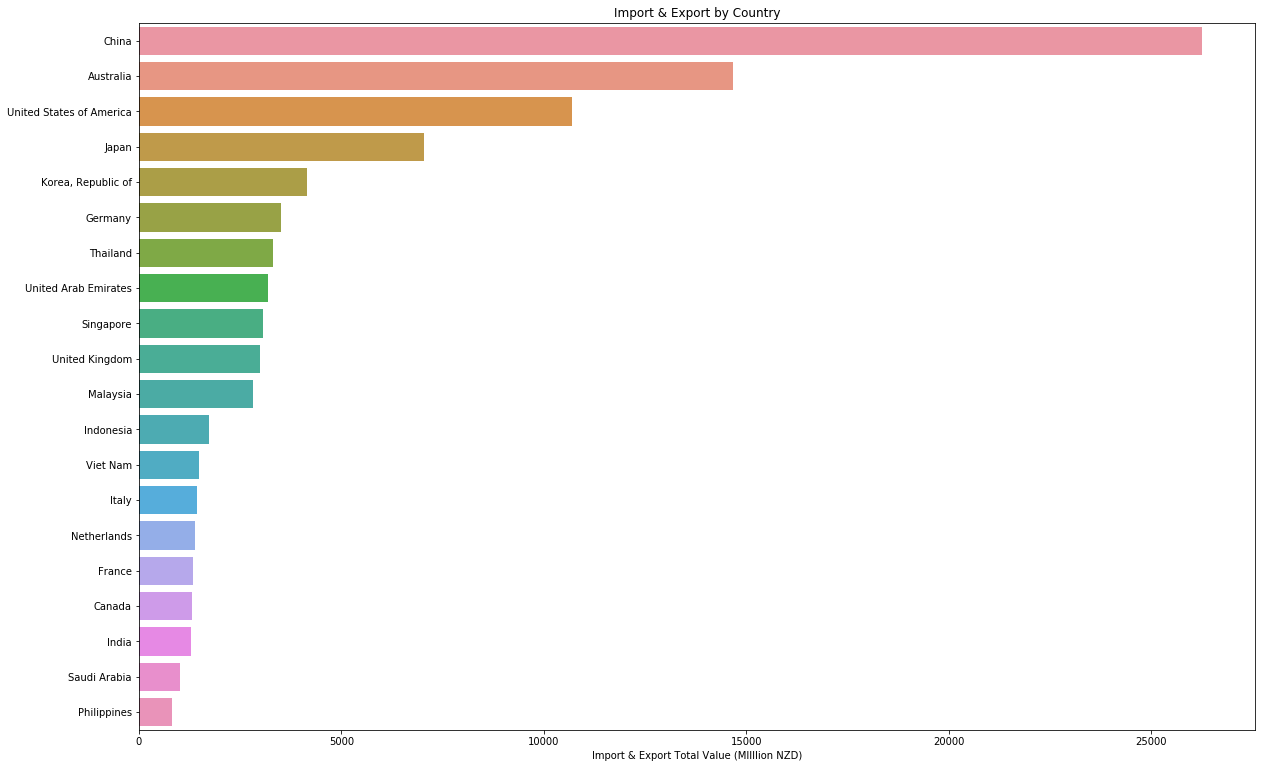

In [14]:
plt.figure(figsize=(20,13))
g=sns.barplot(x='Total',y='Country',data=trade_top20)
g.set(xlabel='Import & Export Total Value (MIlllion NZD)',ylabel='') 
plt.title('Import & Export by Country')
plt.show()

### Load data on major world trade fairs from Wikipedia

In [15]:
# trade fair data 
from bs4 import BeautifulSoup

wiki_url = 'https://en.wikipedia.org/wiki/Trade_fair'
fair_data_columns=['Title','Description','Dates','Location','Visitors']
response = requests.get(wiki_url)
htmlsource = BeautifulSoup(response.text, 'html.parser')
# get "<table class="wikitable sortable">"
fair_table_raw = htmlsource.find("table",{"class":"wikitable sortable"})
wiki_fair_df= pd.read_html(fair_table_raw.prettify(),skiprows=1, flavor='bs4')[0]
 
wiki_fair_df.columns=['0','1','2','3','4']
wiki_fair_df.drop(['0','1','2','4'], axis=1, inplace=True)
#pd.read_html(LOTable.prettify(),skiprows=2, flavor='bs4')


In [16]:
wiki_fair_df.columns=['Country']
wiki_fair_df['Country']=wiki_fair_df['Country'].str.replace('.*,', '')
usaIndexes= wiki_fair_df[wiki_fair_df['Country'].str.contains('United States',regex=False)].index
for i in usaIndexes:
    wiki_fair_df.at[i,'Country']='United States'
chinaIndex= wiki_fair_df[wiki_fair_df['Country'].str.contains('Taiwan|China',regex=True)].index
for i in chinaIndex:
    wiki_fair_df.at[i,'Country']='China'
germanyIndex= wiki_fair_df[wiki_fair_df['Country'].str.contains('Berlin [17]|Germany',regex=True)].index
for i in germanyIndex:
    wiki_fair_df.at[i,'Country']='Germany'
aussieIndex= wiki_fair_df[wiki_fair_df['Country'].str.contains('Australia',regex=True)].index
for i in aussieIndex:
    wiki_fair_df.at[i,'Country']='Australia'             
    
wiki_fair_df['Count']=1    

In [17]:
wiki_fair_df=wiki_fair_df.groupby('Country',axis=0)['Count'].sum()
wiki_fair_df=wiki_fair_df.reset_index('Country')
wiki_fair_df.sort_values(by='Count', ascending =False,axis=0, inplace=True) 
wiki_fair_df.head()

,Country,Count
22,Germany,28
10,Italy,12
23,United States,11
5,France,7
14,Spain,6


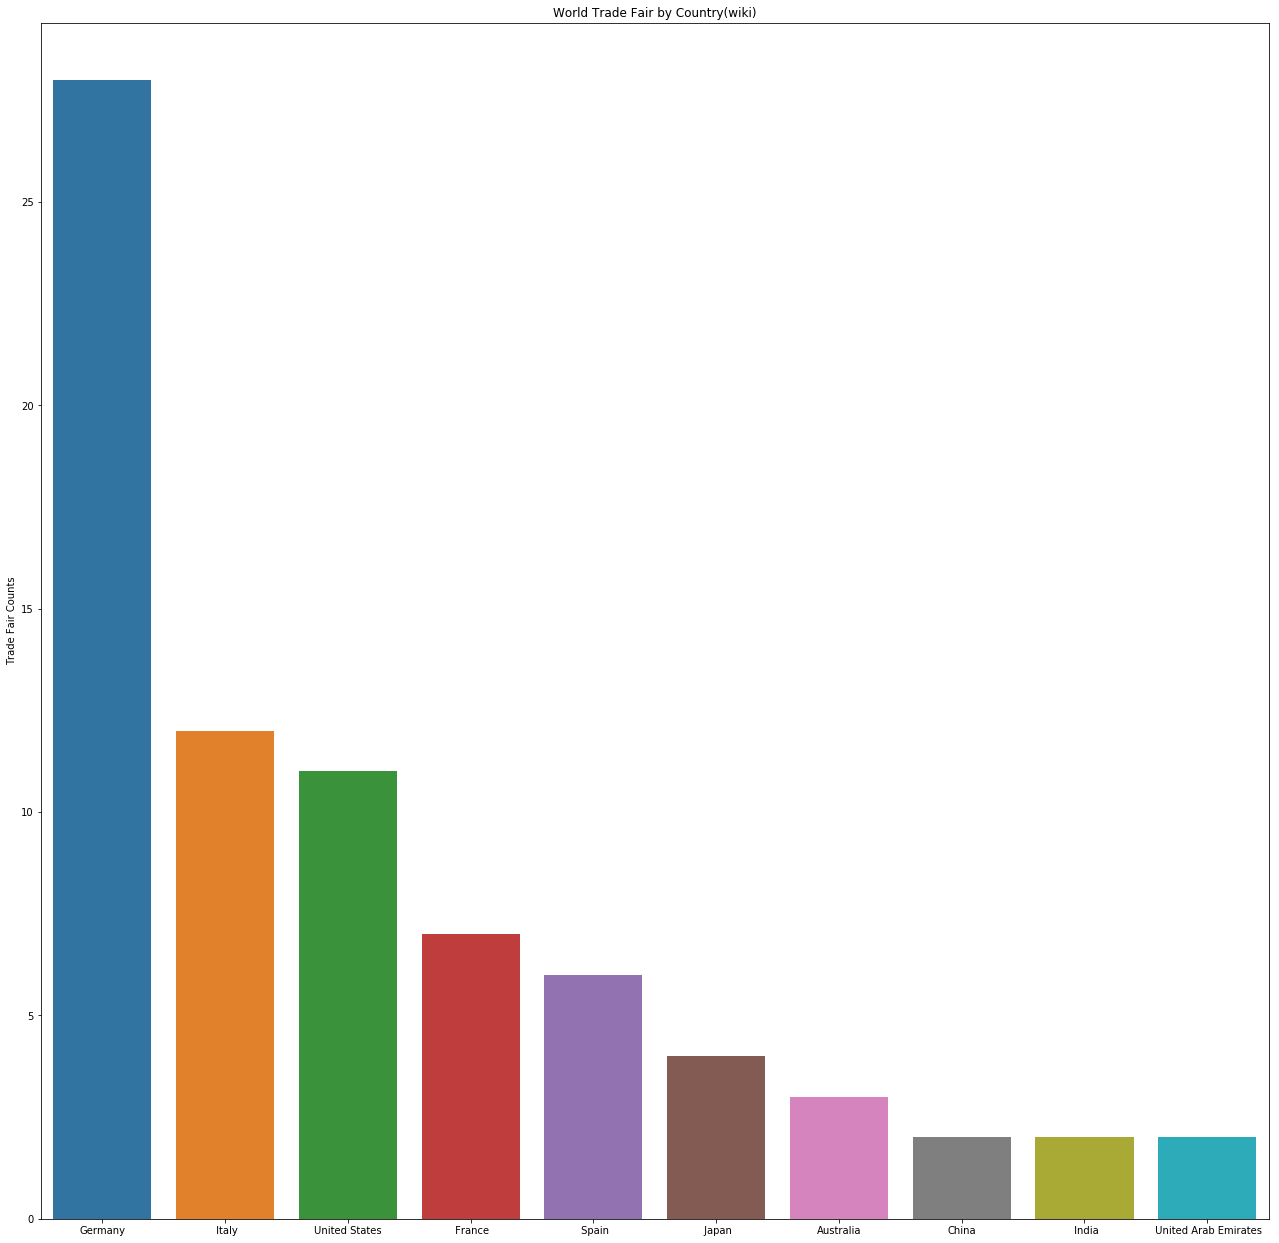

In [18]:
plt.figure(figsize=(22,22))
g= sns.barplot(data=wiki_fair_df.head(10),x='Country', y='Count')
g.set(xlabel='',ylabel='Trade Fair Counts')
plt.title('World Trade Fair by Country(wiki)')
plt.show()

###  Query the nubmer of prosperous cities of New Zealand major trade partners

##### Three factors will be involved in choosing top-ranking  countries: trade volumn, travel frequency, and major trade fair event

In [19]:
#travel_top20 trade_top20 wiki_fair_df
# Update country names for merging 
wiki_fair_df.at[16,'Country']='United Kingdom'
wiki_fair_df.at[23,'Country']='United States of America'

# merge into one df
overall_df = travel_top20.merge( trade_top20, on ='Country', how = 'inner')
overall_df = overall_df.merge( wiki_fair_df, on ='Country', how = 'left')

# drop useless columns 
overall_df.drop(['ExportValue','ImportValue'], axis=1, inplace=True)
overall_df.columns=['Country','TravellerNumber','TradeTotal','TradeFairNumber']

# replace nan values as 0
overall_df = overall_df.fillna(0)
overall_df['TradeFairNumber'] = overall_df['TradeFairNumber'].astype(int)



#### Foursquare International Trade Businee Infomation Function

In [20]:
def GetTradeFairNumbesofCity(checkLocation):
    # import library 
    from IPython.display import Image 
    from IPython.core.display import HTML
    
    # api credential and basic setting 
    CLIENT_ID = 'L2Y2R5HMCAYYCHTIJ2K4CZ--------------------' # your Foursquare ID
    CLIENT_SECRET = 'XW0BTZNSSJWZUPMPWS---------------------' # your Foursquare Secret
    VERSION = '20190114'
    LIMIT = 50 # at most 50; if 50, it indicates business is very active in the city.
    search_query = 'international trade'
    geolocator = Nominatim(user_agent="Logistics Route Research")  
    radius = 10000
    
    # get location for query 
    address = checkLocation#cityName+', '+ countryName
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude 
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    venues = results['response']['venues']    
    venuedf = json_normalize(venues)
    return venuedf.shape[0], latitude, longitude

#### City Information

In [21]:
# exclude cities where 'international trade' venue less than 50 
# if a country has no city listed here, it will be removed the above contry list
cityListByCountry_columns=['City','Country','Latitude', 'Longitude']
citydf=pd.DataFrame(columns=cityListByCountry_columns)
countryList=overall_df.Country.tolist()

In [22]:
#Get the number of busy cities: 
#a prosperous city is defined as within 10 km radius of city center there are over 50 international trade venues marked in Foursquare data

def GetTopCitiesByCountry(topNumber, countryName):
    # get county city list ranked by population
    mongabay_baseurl='https://population.mongabay.com/population/'
    mongabayi_country_url='https://data.mongabay.com/igapo/largest_cities.htm'
    countryResponse=requests.get(mongabayi_country_url)
    countryHtmlSource=BeautifulSoup(countryResponse.text,'html.parser')
    countryLinks = countryHtmlSource.find_all("a",href=True)

    #get city list link 
    tempCountryUrl = ''
    for c in countryLinks:
        internalHref= c['href']
        internalText= c.text
        if(countryName.upper() == internalText.upper()):
            tempCountryUrl=internalHref
            break

    tempCityResponse=requests.get(tempCountryUrl)
    tempCityHtmlSource=BeautifulSoup(tempCityResponse.text,'html.parser')
    tempCityList=tempCityHtmlSource.find('table',{'id':'myTable'})
    tempCitydf=pd.read_html(tempCityList.prettify(),skiprows=0,flavor='bs4')[0]
    if(tempCitydf.shape[0]<topNumber):
        return tempCitydf[0].head().tolist()
    else:
        return tempCitydf[0].head(topNumber).tolist()

In [23]:
#check every country and fetch their prosperous city list 
posi=0
for c in countryList:
    if(c=='United States of America'):
        c='United States'
    if(c == 'Australia'):
        c = 'austria' 
    if(c=='Korea, Republic of'):        
        c='South Korea'
    tempCheckCityList = GetTopCitiesByCountry(topNumber =25, countryName=c)    
    for t in tempCheckCityList:       
        if('Austria' in t):
            t= t.replace('Austria','Australia')
        try:
            buinessNumber,tempLatitude, tempLongitude = GetTradeFairNumbesofCity(checkLocation=t)
            if(buinessNumber==50):
                buinessNumber
                cityCountryPair=t.split(',')                
                citydf.loc[posi]=[cityCountryPair[0].replace(' ',''), cityCountryPair[1],tempLatitude,tempLongitude]                
                posi=posi+1
        except:
            print ('No data for '+ t)
            continue
citydf['Count'] =1

No data for Graz  , Australia
No data for Linz  , Australia
No data for Beijing  , China
No data for Taiâan  , China
No data for HachiÅji  , Japan
No data for HonchÅ  , Japan
No data for DÃ¼sseldorf  , Germany
No data for NÃ¼rnberg  , Germany
No data for KwangmyÅng  , South Korea
No data for Chinju  , South Korea
No data for MontrÃ©al  , Canada
No data for QuÃ©bec  , Canada
No data for Phatthaya  , Thailand
No data for Saint-Ãtienne  , France
No data for NÃ®mes  , France
No data for City of Balikpapan  , Indonesia
No data for DasmariÃ±as  , Philippines


In [24]:
# count prosperous city 
citydf_grouped = citydf.groupby('Country',axis=0)['Count'].sum()
citydf_grouped=citydf_grouped.reset_index('Country')
citydf_grouped['Country'].iloc[14]='United States of America'
citydf_grouped['Country'].iloc[11]='Korea, Republic of'
citydf_grouped.columns=['Country', 'Busy City Number']
citydf_grouped.Country=overall_df.Country
overall_df= overall_df.merge(citydf_grouped, on='Country',how='left')
print('DateFrame size: ' ) 
print(overall_df.shape)

DateFrame size: 
(15, 5)


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### KMeans to group main trade partners of New Zealand

In [25]:
# use KMeans clustering to check the country list
overall_df2=overall_df.copy()
kcluster = 5
overall_df2=overall_df2.drop('Country',1)
kmeans = KMeans(n_clusters=kcluster, random_state=0).fit(overall_df2)
overall_df3=overall_df.copy()
overall_df3['Clustering']=kmeans.labels_
overall_df3



,Country,TravellerNumber,TradeTotal,TradeFairNumber,Busy City Number,Clustering
0,Australia,12.290888,14662.250224,3,7,4
1,China,3.532305,26248.924834,2,16,1
2,United States of America,2.490462,10701.526914,11,4,2
3,United Kingdom,1.755115,2986.542626,2,2,3
4,Japan,0.723610,7048.814862,0,7,2
5,Germany,0.653197,3514.275058,28,8,3
6,"Korea, Republic of",0.575040,4155.468840,0,23,3
7,India,0.546738,1290.019678,0,2,0
8,Canada,0.476311,1306.893581,0,17,0
9,Singapore,0.417135,3074.425087,0,12,3


### Show the map of destinated countries and their prosperous cities

In [26]:
# The map will be centered on Auckland, New Zealand 
#akl_trade_number, akl_latitude, akl_longtitude = GetTradeFairNumbesofCity(checkLocation='Auckland, New Zealand')
akl_trade_number, akl_latitude, akl_longtitude = GetTradeFairNumbesofCity(checkLocation='London, United Kingdom')
!wget --quiet https://ibm.box.com/shared/static/cto2qv7nx6yq19logfcissyy4euo8lho.json -O world_countries.json
world_geo = r'world_countries.json' # geojson file

# create a plain world map
world_map = folium.Map(location=[0, 0], zoom_start=2, tiles='Mapbox Bright')   

In [29]:
world_map=folium.Map(location=[akl_latitude,akl_longtitude],zoom_start=2)
world_map.choropleth(
    geo_data=world_geo,
    data=overall_df3,
    columns=['Country', 'Clustering'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.8,
    legend_name='New Zealand Trade Partner Groups'
)
# add cities to the map 
for index, x in citydf.iterrows():
    folium.CircleMarker(location = ([x.Latitude, x.Longitude]), radius =3, popup=x.City, color='#2b8cbe').add_to(world_map)

# display map
world_map 

### End of data analysis